In [1]:
import pandas as pd
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import tensorflow as tf
# import tensorflow.compat.v1 as tf
from tensorflow import keras
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import os
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import OrderedDict
# from tensorflow.python.ops import math_ops
import tensorflow.keras.backend as kb
from load_data import Files_Load, Boxes, test_split_norm_abnorm, norm_train_max_min


# Kmeans
from sklearn.cluster import KMeans


Using TensorFlow backend.


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  2


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[1],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5500)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


# Load Data

In [6]:
frames = 20
startvid=0
endvid=1

train_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_xywh/Txt_Data/Train_Box/"
test_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_xywh/Txt_Data/Test_Box/"

loc_files_train, loc_files_test, box_train_txt, box_test_txt = Files_Load(train_file, test_file)

traindict = Boxes(loc_files_train, box_train_txt, frames, pad ='pre')
testdict = Boxes(loc_files_test[startvid:endvid], box_test_txt[startvid:endvid], frames, pad ='pre')
abnormal_dict, normal_dict = test_split_norm_abnorm(testdict)

# Normilize data
max1 = traindict['x_ppl_box'].max()
min1 = traindict['x_ppl_box'].min()
xx,yy = norm_train_max_min(data_dict = traindict, max1=max1,min1=min1)
xx_norm,yy_norm = norm_train_max_min(data_dict = normal_dict, max1=max1,min1=min1)
xx_abnorm,yy_abnorm = norm_train_max_min(data_dict = abnormal_dict, max1=max1,min1=min1)


In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
xx_train, xx_val,yy_train,yy_val = train_test_split(xx,yy, test_size = 0.1)
train_univariate = tf.data.Dataset.from_tensor_slices((xx_train,yy_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_univariate = tf.data.Dataset.from_tensor_slices((xx_val,yy_val))
val_univariate = val_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Metrics

# Video Results

In [8]:
def visual_ouput(model=None,max1 = None,min1=None, vid=None,pic_loc =None, output_dict=None,xywh = False):
    # Right now this only works for one video at a time
    
    xx,yy = norm_train_max_min(data_dict = output_dict, max1 = max1,min1 =min1)
    size = len(output_dict['frame_ppl_id'])
    
    #sort index by frames
    frame = []
    for i in range(0,size):
        #sort index by frames
        frame.append(output_dict['frame_ppl_id'][i,-1,0])
    
    frame = np.array(frame)
    sort_index = frame.argsort()
    #Sorted from first to last frame
    xx_scal, yy_scal = xx[sort_index], yy[sort_index]
    vid_file = output_dict['video_file'][sort_index] # not really needed if using one video
    frame_ppl = output_dict['frame_ppl_id'][sort_index]
    y_true = output_dict['y_ppl_box'][sort_index] # not normailized
    
    # Note that predicted outout is already sorted
    y_pred_scal = model.predict(xx_scal)
    y_pred = norm_train_max_min(data=y_pred_scal, max1 = max1,min1 =min1,undo_norm=True)
    

    stop = frame[sort_index][-1] + 1
    next_frame_index,j = 0,0
    
    #  Start Video
    loc_videos ="/home/akanu/Dataset/Anomaly/Avenue_Dataset/testing_videos/{:02}.avi".format(vid)
    video_capture = cv2.VideoCapture(loc_videos)

    if xywh:
        y_pred[:,0] = y_pred[:,0] - y_pred[:,2]/2
        y_pred[:,1] = y_pred[:,1] - y_pred[:,3]/2 # Now we are at tlwh
        y_pred[:,2:] = y_pred[:,:2] + y_pred[:,2:]
        
        y_true[:,0] = y_true[:,0] - y_true[:,2]/2
        y_true[:,1] = y_true[:,1] - y_true[:,3]/2 # Now we are at tlwh
        y_true[:,2:] = y_true[:,:2] + y_true[:,2:]
        
    for i in range(0,stop):
        ret, frame = video_capture.read()
        if i == frame_ppl[j,-1,0]: #finds the frame
            while i == frame_ppl[j,-1,0]:
                y_fr_act = y_true[j]
                y_fr_pred = y_pred[j]
                id1 = frame_ppl[j,-1,1]
#                 print("{}  ,{}".format(y_fr_act.shape, y_fr_pred.shape))

                gt_frame = frame.copy()
                pred_frame = frame.copy()
                both_frame = frame.copy()

    
                # Ground Truth
                cv2.rectangle(gt_frame, (int(y_fr_act[0]), int(y_fr_act[1])), (int(y_fr_act[2]), int(y_fr_act[3])),(0,255,0), 2)
#                 cv2.putText(gt_frame, str(frame_ppl[j,-1,1]),(int(y_fr_act[0]), int(y_fr_act[1])),0, 5e-3 * 200, (255,255,0),2)
                
                # Predicted
                cv2.rectangle(pred_frame, (int(y_fr_pred[0]), int(y_fr_pred[1])), (int(y_fr_pred[2]), int(y_fr_pred[3])),(0,255,255), 2)
#                 cv2.putText(pred_frame, str(frame_ppl[j,-1,1]),(int(y_fr_pred[2]), int(y_fr_pred[3])),0, 5e-3 * 200, (255,255,0),2)
                
                # Combined frame
                cv2.rectangle(both_frame, (int(y_fr_act[0]), int(y_fr_act[1])), (int(y_fr_act[2]), int(y_fr_act[3])),(0,255,0), 2)
#                 cv2.putText(both_frame, str(frame_ppl[j,-1,1]),(int(y_fr_act[0]), int(y_fr_act[1])),0, 5e-3 * 200, (255,255,0),2)
                cv2.rectangle(both_frame, (int(y_fr_pred[0]), int(y_fr_pred[1])), (int(y_fr_pred[2]), int(y_fr_pred[3])),(0,255,255), 2)
#                 cv2.putText(both_frame, str(frame_ppl[j,-1,1]),(int(y_fr_pred[2]), int(y_fr_pred[3])),0, 5e-3 * 200, (255,255,0),2)
                
                
                cv2.imwrite(pic_loc.format(vid,i,id1) + '_gt.jpg', gt_frame)
                cv2.imwrite(pic_loc.format(vid,i,id1) + '_pred.jpg', pred_frame)
                cv2.imwrite(pic_loc.format(vid,i,id1) + '_both.jpg', both_frame)



                
                next_frame_index +=1
                j = next_frame_index
#                 print('saved')
#                 print(j)
                if j == size:
                    return

In [12]:
def bb_intersection_over_union(y, x):
   
    xA = kb.max((x[:,0:1],y[:,0:1]), axis=0,keepdims=True)
    yA = kb.max((x[:,1:2],y[:,1:2]), axis=0,keepdims=True)
    xB = kb.min((x[:,2:3],y[:,2:3]), axis=0,keepdims=True)
    yB = kb.min((x[:,3:4],y[:,3:4]), axis=0,keepdims=True)

    interArea1 = kb.max((kb.zeros_like(xB), (xB-xA +1) ), axis=0, keepdims=True)
    interArea2 = kb.max((kb.zeros_like(xB), (yB-yA +1) ), axis=0, keepdims=True)
    interArea = interArea1*interArea2
    boxAArea = (x[:,2:3] - x[:,0:1] + 1) * (x[:,3:4] - x[:,1:2] + 1)
    boxBArea = (y[:,2:3] - y[:,0:1] + 1) * (y[:,3:4] - y[:,1:2] + 1)

    iou = interArea / (boxAArea + boxBArea - interArea)
    iou_mean = -kb.mean(iou)
    return iou_mean

In [13]:
with tf.device('/device:GPU:1'):
    lstm_20 = keras.Sequential()
    lstm_20.add(keras.layers.InputLayer(input_shape=xx.shape[-2:]))
    lstm_20.add(keras.layers.LSTM(4,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(3,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(6,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(4,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(4,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(4) )
    lstm_20.add(keras.layers.Dense(4) )
    opt = tf.keras.optimizers.Adam(learning_rate=8.726e-06)
    checkpoint_cb = keras.callbacks.ModelCheckpoint("lstm_5_xywh.h5", 
                                                       save_best_only = True)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5)
    lstm_20.compile(optimizer=opt, loss=bb_intersection_over_union_xywh, metrics='mse')
    
    lstm_20_history_1= lstm_20.fit(train_univariate,
                               validation_data = val_univariate,
                               epochs=100)
#                                callbacks = [early_stopping, checkpoint_cb])

Epoch 1/100
  70/3902 [..............................] - ETA: 1:18 - loss: -0.2531 - mse: 0.1255

KeyboardInterrupt: 

In [ ]:
model.predict(xx_norm)

In [ ]:
pic_loc = "/home/akanu/git/anomalous_pred/resulting_images/xywh/test_abnorm/{}_{}_{}"
visual_ouput(model=lstm_20,max1 = max1, min1=min1, vid=1,pic_loc =pic_loc, output_dict=abnormal_dict,xywh = True)

In [ ]:
pic_loc = "/home/akanu/git/anomalous_pred/resulting_images/xywh/test_norm/{}_{}_{}"
visual_ouput(model=lstm_20,max1 = max1, min1=min1, vid=1,pic_loc =pic_loc, output_dict=normal_dict,xywh = True)

In [ ]:
lstm_20.evaluate(xx_norm, yy_norm)

# K means Clustering Approach

https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1

In [36]:
# model=lstm_20
model = tf.keras.models.load_model('lstm_5_xywh.h5', custom_objects = {'loss':bb_intersection_over_union} , compile=False)

In [37]:
xx_test,yy_test= norm_train_max_min(data_dict = testdict, max1=max1,min1=min1)


In [1]:
y_pred_scal = model.predict(xx_test)
y_pred = norm_train_max_min(data=y_pred_scal, max1 = max1,min1 =min1,undo_norm=True)

NameError: name 'model' is not defined

In [39]:
kmean_scal = KMeans(n_clusters=2)
kmean = KMeans(n_clusters=2)

In [40]:
kmean_scal.fit(y_pred_scal[:,0:2])
kmean.fit(y_pred[:,0:2])

KMeans(n_clusters=2)

In [41]:
out = kmean_scal.cluster_centers_
out

array([[0.62442684, 0.3404834 ],
       [0.34323338, 0.34202182]], dtype=float32)

In [42]:
out1 = kmean.cluster_centers_
out1

array([[491.25027, 170.38733],
       [175.25414, 172.09264]], dtype=float32)

In [43]:
traindict.keys()

dict_keys(['x_ppl_box', 'y_ppl_box', 'frame_ppl_id', 'video_file', 'abnormal'])

In [44]:
traindict['frame_ppl_id'][0:3].shape

(3, 21, 2)

In [30]:
ped = pedsort(testdict)

In [33]:
j='86'
x,y = norm_train_max_min(data_dict=ped[j], max1=max1, min1=min1 )

out1 = model.predict(x)
bb_intersection_over_union(out1,y)

<tf.Tensor: shape=(), dtype=float64, numpy=-0.8640143823782842>

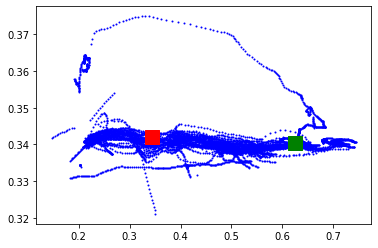

In [45]:

plt.scatter(y_pred_scal[:,0], y_pred_scal[:,1],s=1, c='b')
plt.scatter(out[0,0], out[0,1],s=200, c ='g', marker='s')
plt.scatter(out[1,0], out[1,1], s=200, c ='r', marker='s')

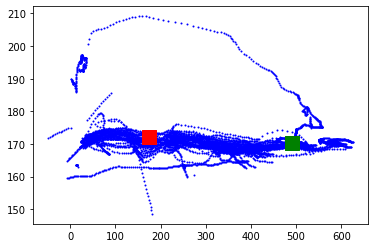

In [46]:
plt.scatter(y_pred[:,0], y_pred[:,1],s=1, c='b')
plt.scatter(out1[0,0], out1[0,1],s=200, c ='g', marker='s')
plt.scatter(out1[1,0], out1[1,1], s=200, c ='r', marker='s')

Suggestion that x,y is not enough to create a hyoer parameter to seperate abnomaly and normal pedestrains. Makes sense because abnormal and normal pedestrains walk over the same spatial features. Trying to do it for all pedestrains 

# Sorting data

In [ ]:
testdict.keys()

In [ ]:
oneperson = KMeans(n_clusters=2)
oneperson.fit(testdict['y_ppl_box'][:368,0:2])


In [ ]:
out = oneperson.cluster_centers_

In [ ]:
plt.scatter(testdict['y_ppl_box'][:368,0], testdict['y_ppl_box'][:368,1],s=1, c='b')
plt.xlabel('X')
plt.ylabel('Y')

In [ ]:
plt.scatter(testdict['y_ppl_box'][:368,2], testdict['y_ppl_box'][:368,3],s=1, c='b')
plt.xlabel('Width')
plt.ylabel('Height')

# plt.scatter(out[0,0], out[0,1],s=200, c ='g', marker='s')
# plt.scatter(out[1,0], out[1,1], s=200, c ='r', marker='s')

In [ ]:
plt.scatter(testdict['y_ppl_box'][1194:1481,0], testdict['y_ppl_box'][1194:1481,1],s=1, c='b')
plt.xlabel('X')
plt.ylabel('Y')

In [ ]:
plt.scatter(testdict['y_ppl_box'][1194:1481,2], testdict['y_ppl_box'][1194:1481,3],s=1, c='b')
plt.xlabel('Width')
plt.ylabel('Height')

# Pedestrain

In [29]:
def pedsort(datadict):
    
    ped = {}
    
    # For each pedestrain want to create a new key
    per_id = np.unique(datadict['frame_ppl_id'][:,-1,1])
    for i in per_id:
        ped[str(i)] = {}
        index = np.where(datadict['frame_ppl_id'][:,-1,1] == i)
        # should ensure it sorted by frame
        temp = {}
        for key in datadict.keys():
            temp[key] = datadict[key][index]
            
        ped[str(i)] = temp
    return ped
        
    
        

In [ ]:
ped = pedsort(testdict)

In [ ]:
j = '79'
out = model.predict(ped[j]['x_ppl_box'])
out = norm_train_max_min(data=out, max1 = max1,min1 =min1,undo_norm=True)

In [ ]:
xy_diff = []
for i in range(1,len(out)):
    
    xy_diff.append(out[i,:] - out[i-1,:])

xy_diff = np.array(xy_diff)
out =np.sum(np.square(xy_diff[:,0:2]), axis=1)
    

In [ ]:
plt.plot(ped[j]['frame_ppl_id'][1:,-1,0], out,'*')
# plt.plot(ped['1']['frame_ppl_id'][1:,-1,0], xy_diff[:,0],'-+')
# plt.plot(ped['1']['frame_ppl_id'][1:,-1,0], xy_diff[:,1],'-0')

In [ ]:
ped[j]['abnormal']

# Abnormal Through IOU

In [ ]:
def bb_intersection_over_union_np(y, x):
    xA = np.max((x[:,0:1],y[:,0:1]), axis=0,keepdims=True)
    yA = np.max((x[:,1:2],y[:,1:2]), axis=0,keepdims=True)
    xB = np.min((x[:,2:3],y[:,2:3]), axis=0,keepdims=True)
    yB = np.min((x[:,3:4],y[:,3:4]), axis=0,keepdims=True)

    interArea1 = np.max((np.zeros_like(xB), (xB-xA +1) ), axis=0, keepdims=True)
    interArea2 = np.max((np.zeros_like(xB), (yB-yA +1) ), axis=0, keepdims=True)
    interArea = interArea1*interArea2
    boxAArea = (x[:,2:3] - x[:,0:1] + 1) * (x[:,3:4] - x[:,1:2] + 1)
    boxBArea = (y[:,2:3] - y[:,0:1] + 1) * (y[:,3:4] - y[:,1:2] + 1)

    iou = interArea / (boxAArea + boxBArea - interArea)
#     iou_mean = -np.mean(iou)
    return iou

In [ ]:
def xywh_tlbr(data):
    data = data.astype(float)
    data[:,0] = data[:,0] - data[:,2]/2
    data[:,1] = data[:,1] - data[:,3]/2
    data[:,2] = data[:,0] + data[:,2]
    data[:,3] = data[:,1] + data[:,3]
    
    return data

In [ ]:
xywh_tlbr(np.array([[4,4,4,4]]))

In [ ]:
j ='1'
out1 = lstm_20.predict(ped[j]['x_ppl_box'])
out = norm_train_max_min(data=out1, max1 = max1,min1 =min1,undo_norm=True)
bb_intersection_over_union(xywh_tlbr(out), xywh_tlbr(ped[j]['y_ppl_box']))

In [ ]:
xywh_tlbr(out)

In [ ]:
ped[j]['y_ppl_box']

In [ ]:
x,y = norm_train_max_min(data_dict=ped[j], max1=max1, min1=min1 )

model.evaluate(x,y)

In [ ]:
bb_intersection_over_union(out,y)


In [ ]:
model = tf.keras.models.load_model('lstm_5_xywh.h5', custom_objects = {'loss':bb_intersection_over_union} , compile=False)